In [12]:
from circuits.cp_fraction import cp_fraction
from src.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from src.FM_methods import set_initial_partitions
from qiskit.circuit.library import QFT, QuantumVolume
from circuits.QAOA import QAOA_random
from src.FM_main import run_main_algorithm
import time
from src.multilevel_FM import multilevel_FM
from src.hypergraph_coarsening import coarsen_hypergraph_full

num_qubits = 48
num_partitions = 6

size = 8

num_runs = 10

frac = 0.9

iterations = 1
time_list_outer = []
time_list_ML_outer = []

for run in range(5,num_runs):
    num_qubits = num_qubits + size
    num_partitions = num_partitions + 1
    qpu_size = int(num_qubits / num_partitions) + 1
    qpu_info = [qpu_size] * num_partitions

    circuit = cp_fraction(  num_qubits=num_qubits,
                            depth=num_qubits,
                            fraction= frac )

    circuit = transpile(circuit, basis_gates = ['cp', 'u'])
    depth = circuit.depth() + 2

    graph = QuantumCircuitHyperGraph(num_qubits=num_qubits, depth=depth)
    graph.map_circuit_to_hypergraph(circuit, group_gates=True)
    
    cost_list = []
    time_list = []

    cost_list_ML = []
    time_list_ML = []
    print("Run: ", run)
    print("Qubits: ", num_qubits)
    print("Qpu info: ", qpu_info)

    coarsened_hypergraphs = coarsen_hypergraph_full(graph, depth)

    for iter in range(iterations):
        initial_assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)
        start = time.time()
        cost, assignment_list = run_main_algorithm(hypergraph=graph, 
                                                    initial_assignment=initial_assignment,
                                                    qpu_info=qpu_info,
                                                    num_qubits=num_qubits,
                                                    num_partitions=num_partitions,
                                                    limit = num_qubits*depth/8,
                                                    max_gain=4,
                                                    passes=100,
                                                    stochastic=True,
                                                    log=True)
        stop = time.time()
        print("Iteration: ", iter)
        print("Cost: ", cost)
        time_taken = stop - start
        cost_list.append(cost)
        time_list.append(time_taken)
        print("Time taken: ", time_taken)

        num_levels = 8
        start = time.time()
        assignment_list, cost_list = multilevel_FM(coarsened_hypergraphs=coarsened_hypergraphs,
                                                base_assignment=initial_assignment[0],
                                                num_partitions=num_partitions,
                                                qpu_info=qpu_info,
                                                num_qubits=num_qubits,
                                                num_levels=num_levels,
                                                limit = num_qubits*depth/16,
                                                pass_list=[10]*(num_levels+2),
                                                stochastic=True,
                                                lock_nodes=False,
                                                log=False)
        cost_ML = min(cost_list)
        stop = time.time()
        print("Iteration: ", iter)
        print("Cost Multilevel: ", cost_ML)
        time_taken_ML = stop - start
        cost_list_ML.append(cost_ML)
        time_list_ML.append(time_taken_ML)
        print("Time taken Multilevel: ", time_taken_ML)

    min_cost = min(cost_list)
    min_cost_ML = min(cost_list_ML)
    avg_time = sum(time_list)/len(time_list)
    avg_time_ML = sum(time_list_ML)/len(time_list_ML)

    time_list_outer.append(avg_time)
    time_list_ML_outer.append(avg_time_ML)
        


    





Run:  5
Qubits:  56
Qpu info:  [9, 9, 9, 9, 9, 9, 9]
Initial cost: 645
All passes complete.
Final cost: 565
Iteration:  0
Cost:  565
Time taken:  109.98667311668396
Iteration:  0
Cost Multilevel:  508
Time taken Multilevel:  43.98009204864502
Run:  6
Qubits:  64
Qpu info:  [9, 9, 9, 9, 9, 9, 9, 9]
Initial cost: 815
All passes complete.
Final cost: 712
Iteration:  0
Cost:  712
Time taken:  213.2685570716858
Iteration:  0
Cost Multilevel:  698
Time taken Multilevel:  87.03757166862488
Run:  7
Qubits:  72
Qpu info:  [9, 9, 9, 9, 9, 9, 9, 9, 9]
Initial cost: 1125
All passes complete.
Final cost: 968
Iteration:  0
Cost:  968
Time taken:  316.12401604652405
Iteration:  0
Cost Multilevel:  935
Time taken Multilevel:  122.70912408828735
Run:  8
Qubits:  80
Qpu info:  [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Initial cost: 1427
All passes complete.
Final cost: 1217
Iteration:  0
Cost:  1217
Time taken:  521.1998767852783
Iteration:  0
Cost Multilevel:  1158
Time taken Multilevel:  206.8434829711914
Run:  

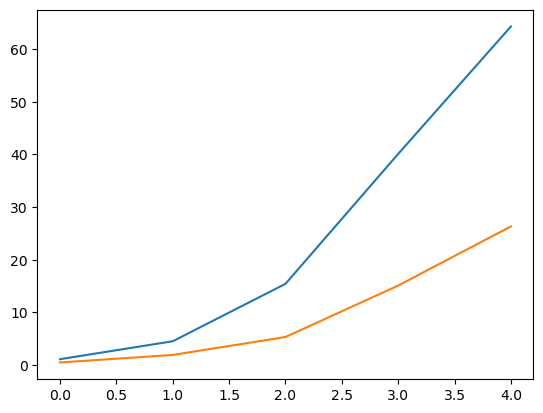

In [9]:
import matplotlib.pyplot as plt

plt.plot(time_list_outer, label='Outer')
plt.plot(time_list_ML_outer, label='ML Outer')